# Transformer Network

Welcome to Week 4's assignment, the last assignment of Course 5 of the Deep Learning Specialization! And congratulations on making it to the last assignment of the entire Deep Learning Specialization - you're almost done!

Ealier in the course, you've implemented sequential neural networks such as RNNs, GRUs, and LSTMs. In this notebook you'll explore the Transformer architecture, a neural network that takes advantage of parallel processing and allows you to substantially speed up the training process. 

**After this assignment you'll be able to**:

* Create positional encodings to capture sequential relationships in data
* Calculate scaled dot-product self-attention with word embeddings
* Implement masked multi-head attention
* Build and train a Transformer model

For the last time, let's get started!

## Table of Contents

- [Packages](#0)
- [1 - Positional Encoding](#1)
    - [1.1 - Sine and Cosine Angles](#1-1)
        - [Exercise 1 - get_angles](#ex-1)
    - [1.2 - Sine and Cosine Positional Encodings](#1-2)
        - [Exercise 2 - positional_encoding](#ex-2)
- [2 - Masking](#2)
    - [2.1 - Padding Mask](#2-1)
    - [2.2 - Look-ahead Mask](#2-2)
- [3 - Self-Attention](#3)
    - [Exercise 3 - scaled_dot_product_attention](#ex-3)
- [4 - Encoder](#4)
    - [4.1 Encoder Layer](#4-1)
        - [Exercise 4 - EncoderLayer](#ex-4)
    - [4.2 - Full Encoder](#4-2)
        - [Exercise 5 - Encoder](#ex-5)
- [5 - Decoder](#5)
    - [5.1 - Decoder Layer](#5-1)
        - [Exercise 6 - DecoderLayer](#ex-6)
    - [5.2 - Full Decoder](#5-2)
        - [Exercise 7 - Decoder](#ex-7)
- [6 - Transformer](#6)
    - [Exercise 8 - Transformer](#ex-8)
- [7 - References](#7)

<a name='0'></a>
## Packages

Run the following cell to load the packages you'll need.

In [1]:
import tensorflow as tf
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, Input, Dropout, LayerNormalization
from transformers import DistilBertTokenizerFast #, TFDistilBertModel
from transformers import TFDistilBertForTokenClassification
from tqdm import tqdm_notebook as tqdm

2023-09-11 21:12:41.280876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<a name='1'></a>
## 1 - Positional Encoding

In sequence to sequence tasks, the relative order of your data is extremely important to its meaning. When you were training sequential neural networks such as RNNs, you fed your inputs into the network in order. Information about the order of your data was automatically fed into your model.  However, when you train a Transformer network, you feed your data into the model all at once. While this dramatically reduces training time, there is no information about the order of your data. This is where positional encoding is useful - you can specifically encode the positions of your inputs and pass them into the network using these sine and cosine formulas:
    
$$
PE_{(pos, 2i)}= sin\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
\tag{1}$$
<br>
$$
PE_{(pos, 2i+1)}= cos\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
\tag{2}$$

* $d$ is the dimension of the word embedding and positional encoding
* $pos$ is the position of the word.
* $i$ refers to each of the different dimensions of the positional encoding.

The values of the sine and cosine equations are small enough (between -1 and 1) that when you add the positional encoding to a word embedding, the word embedding is not significantly distorted. The sum of the positional encoding and word embeding is ultimately what is fed into the model. Using a combination of these two equations helps your Transformer network attend to the relative positions of your input data. Note that while in the lectures Andrew uses vertical vectors but in this assignment, all vectors are horizontal. All matrix multiplications should be adjusted accordingly.

<a name='1-1'></a>
### 1.1 - Sine and Cosine Angles

Get the possible angles used to compute the positional encodings by calculating the inner term of the sine and cosine equations: 

$$\frac{pos}{10000^{\frac{2i}{d}}} \tag{3}$$

<a name='ex-1'></a>
### Exercise 1 - get_angles

Implement the function `get_angles()` to calculate the possible angles for the sine and cosine  positional encodings

In [2]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION get_angles
def get_angles(pos, i, d):
    """
    Get the angles for the positional encoding
    
    Arguments:
        pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
        i --   Row vector containing the dimension span [[0, 1, 2, ..., M-1]]
        d(integer) -- Encoding size
    
    Returns:
        angles -- (pos, d) numpy array 
    """
    # START CODE HERE
    angles = pos/ (np.power(10000, (2 * (i//2)) / np.float32(d)))
    # END CODE HERE
    
    return angles

In [3]:
# UNIT TEST
def get_angles_test(target):
    position = 4
    d_model = 16
    pos_m = np.arange(position)[:, np.newaxis]
    dims = np.arange(d_model)[np.newaxis, :]

    result = target(pos_m, dims, d_model)

    assert type(result) == np.ndarray, "You must return a numpy ndarray"
    assert result.shape == (position, d_model), f"Wrong shape. We expected: ({position}, {d_model})"
    assert np.sum(result[0, :]) == 0
    assert np.isclose(np.sum(result[:, 0]), position * (position - 1) / 2)
    even_cols =  result[:, 0::2]
    odd_cols = result[:,  1::2]
    assert np.all(even_cols == odd_cols), "Submatrices of odd and even columns must be equal"
    limit = (position - 1) / np.power(10000,14.0/16.0)
    assert np.isclose(result[position - 1, d_model -1], limit ), f"Last value must be {limit}"

    print("\033[92mAll tests passed")

get_angles_test(get_angles)

# Example
position = 4
d_model = 8
pos_m = np.arange(position)[:, np.newaxis]
dims = np.arange(d_model)[np.newaxis, :]
get_angles(pos_m, dims, d_model)

All tests passed


array([[0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [1.e+00, 1.e+00, 1.e-01, 1.e-01, 1.e-02, 1.e-02, 1.e-03, 1.e-03],
       [2.e+00, 2.e+00, 2.e-01, 2.e-01, 2.e-02, 2.e-02, 2.e-03, 2.e-03],
       [3.e+00, 3.e+00, 3.e-01, 3.e-01, 3.e-02, 3.e-02, 3.e-03, 3.e-03]])

<a name='1-2'></a>
### 1.2 - Sine and Cosine Positional Encodings

Now you can use the angles you computed to calculate the sine and cosine positional encodings.

$$
PE_{(pos, 2i)}= sin\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
$$
<br>
$$
PE_{(pos, 2i+1)}= cos\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
$$

<a name='ex-2'></a>
### Exercise 2 - positional_encoding

Implement the function `positional_encoding()` to calculate the sine and cosine  positional encodings

**Reminder:** Use the sine equation when $i$ is an even number and the cosine equation when $i$ is an odd number.

#### Additional Hints
* You may find 
[np.newaxis](https://numpy.org/doc/stable/reference/arrays.indexing.html) useful depending on the implementation you choose. 

In [4]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION positional_encoding
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int) -- Maximum number of positions to be encoded 
        d (int) -- Encoding size 
    
    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    # START CODE HERE
    # initialize a matrix angle_rads of all the angles 
    angle_rads = get_angles(np.arange(positions)[:, np.newaxis],
                            np.arange(d)[ np.newaxis,:],
                            d)
  
    # -> angle_rads has dim (positions,d)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    # END CODE HERE
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

In [5]:
# UNIT TEST
def positional_encoding_test(target):
    position = 8
    d_model = 16

    pos_encoding = target(position, d_model)
    sin_part = pos_encoding[:, :, 0::2]
    cos_part = pos_encoding[:, :, 1::2]

    assert tf.is_tensor(pos_encoding), "Output is not a tensor"
    assert pos_encoding.shape == (1, position, d_model), f"Wrong shape. We expected: (1, {position}, {d_model})"

    ones = sin_part ** 2  +  cos_part ** 2
    assert np.allclose(ones, np.ones((1, position, d_model // 2))), "Sum of square pairs must be 1 = sin(a)**2 + cos(a)**2"
    
    angs = np.arctan(sin_part / cos_part)
    angs[angs < 0] += np.pi
    angs[sin_part.numpy() < 0] += np.pi
    angs = angs % (2 * np.pi)
    
    pos_m = np.arange(position)[:, np.newaxis]
    dims = np.arange(d_model)[np.newaxis, :]

    trueAngs = get_angles(pos_m, dims, d_model)[:, 0::2] % (2 * np.pi)
    
    assert np.allclose(angs[0], trueAngs), "Did you apply sin and cos to even and odd parts respectively?"
 
    print("\033[92mAll tests passed")

    
positional_encoding_test(positional_encoding)


All tests passed


Nice work calculating the positional encodings! Now you can visualize them.

(1, 50, 512)


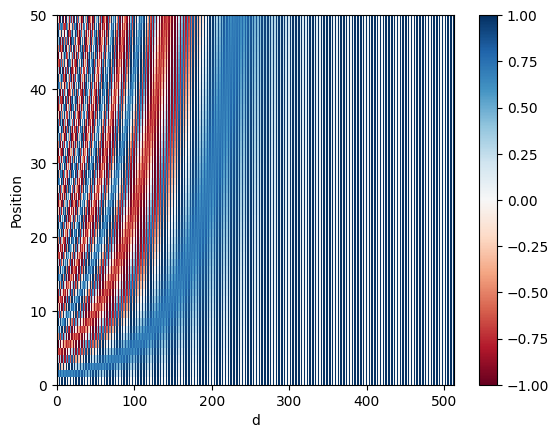

In [5]:
pos_encoding = positional_encoding(50, 512)

print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

Each row represents a positional encoding - notice how none of the rows are identical! You have created a unique positional encoding for each of the words.

<a name='2'></a>
## 2 - Masking

There are two types of masks that are useful when building your Transformer network: the *padding mask* and the *look-ahead mask*. Both help the softmax computation give the appropriate weights to the words in your input sentence. 

<a name='2-1'></a>
### 2.1 - Padding Mask

Oftentimes your input sequence will exceed the maximum length of a sequence your network can process. Let's say the maximum length of your model is five, it is fed the following sequences:

    [["Do", "you", "know", "when", "Jane", "is", "going", "to", "visit", "Africa"], 
     ["Jane", "visits", "Africa", "in", "September" ],
     ["Exciting", "!"]
    ]

which might get vectorized as:

    [[ 71, 121, 4, 56, 99, 2344, 345, 1284, 15],
     [ 56, 1285, 15, 181, 545],
     [ 87, 600]
    ]
    
When passing sequences into a transformer model, it is important that they are of uniform length. You can achieve this by padding the sequence with zeros, and truncating sentences that exceed the maximum length of your model:

    [[ 71, 121, 4, 56, 99],
     [ 2344, 345, 1284, 15, 0],
     [ 56, 1285, 15, 181, 545],
     [ 87, 600, 0, 0, 0],
    ]
    
Sequences longer than the maximum length of five will be truncated, and zeros will be added to the truncated sequence to achieve uniform length. Similarly, for sequences shorter than the maximum length, they zeros will also be added for padding. However, these zeros will affect the softmax calculation - this is when a padding mask comes in handy! By multiplying a padding mask by -1e9 and adding it to your sequence, you mask out the zeros by setting them to close to negative infinity. We'll implement this for you so you can get to the fun of building the Transformer network! 😇 Just make sure you go through the code so you can correctly implement padding when building your model. 

After masking, your input should go from `[87, 600, 0, 0, 0]` to `[87, 600, -1e9, -1e9, -1e9]`, so that when you take the softmax, the zeros don't affect the score.

In [7]:
def create_padding_mask(seq):
    """
    Creates a matrix mask for the padding cells
    
    Arguments:
        seq -- (n, m) matrix
    
    Returns:
        mask -- (n, 1, 1, m) binary tensor
    """
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :] 

In [8]:
x = tf.constant([[7., 6., 0., 0., 1.], [1., 2., 3., 0., 0.], [0., 0., 0., 4., 5.]])
print(create_padding_mask(x))

tf.Tensor(
[[[[0. 0. 1. 1. 0.]]]


 [[[0. 0. 0. 1. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(3, 1, 1, 5), dtype=float32)


If we multiply this mask by -1e9 and add it to the sample input sequences, the zeros are essentially set to negative infinity. Notice the difference when taking the softmax of the original sequence and the masked sequence:

In [9]:
print(tf.keras.activations.softmax(x))
print(tf.keras.activations.softmax(x + create_padding_mask(x) * -1.0e9))

tf.Tensor(
[[7.2876644e-01 2.6809821e-01 6.6454901e-04 6.6454901e-04 1.8064314e-03]
 [8.4437378e-02 2.2952460e-01 6.2391251e-01 3.1062774e-02 3.1062774e-02]
 [4.8541026e-03 4.8541026e-03 4.8541026e-03 2.6502505e-01 7.2041273e-01]], shape=(3, 5), dtype=float32)
tf.Tensor(
[[[[7.2973627e-01 2.6845497e-01 0.0000000e+00 0.0000000e+00
    1.8088354e-03]
   [2.4472848e-01 6.6524094e-01 0.0000000e+00 0.0000000e+00
    9.0030573e-02]
   [6.6483547e-03 6.6483547e-03 0.0000000e+00 0.0000000e+00
    9.8670328e-01]]]


 [[[7.3057163e-01 2.6876229e-01 6.6619506e-04 0.0000000e+00
    0.0000000e+00]
   [9.0030573e-02 2.4472848e-01 6.6524094e-01 0.0000000e+00
    0.0000000e+00]
   [3.3333334e-01 3.3333334e-01 3.3333334e-01 0.0000000e+00
    0.0000000e+00]]]


 [[[0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6894143e-01
    7.3105860e-01]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 5.0000000e-01
    5.0000000e-01]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6894143e-01
    7.3105860e-01]]]], shape

<a name='2-2'></a>
### 2.2 - Look-ahead Mask

The look-ahead mask follows similar intuition. In training, you will have access to the complete correct output of your training example. The look-ahead mask helps your model pretend that it correctly predicted a part of the output and see if, *without looking ahead*, it can correctly predict the next output. 

For example, if the expected correct output is `[1, 2, 3]` and you wanted to see if given that the model correctly predicted the first value it could predict the second value, you would mask out the second and third values. So you would input the masked sequence `[1, -1e9, -1e9]` and see if it could generate `[1, 2, -1e9]`.

Just because you've worked so hard, we'll also implement this mask for you 😇😇. Again, take a close look at the code so you can effictively implement it later.

In [10]:
def create_look_ahead_mask(size):
    """
    Returns an upper triangular matrix filled with ones
    
    Arguments:
        size -- matrix size
    
    Returns:
        mask -- (size, size) tensor
    """
    mask = tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask 

In [11]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [1., 1., 0.],
       [1., 1., 1.]], dtype=float32)>

<a name='3'></a>
## 3 - Self-Attention

As the authors of the Transformers paper state, "Attention is All You Need". 

<img src="self-attention.png" alt="Encoder" width="600"/>
<caption><center><font color='purple'><b>Figure 1: Self-Attention calculation visualization</font></center></caption>
    
The use of self-attention paired with traditional convolutional networks allows for the parallization which speeds up training. You will implement **scaled dot product attention** which takes in a query, key, value, and a mask as inputs to returns rich, attention-based vector representations of the words in your sequence. This type of self-attention can be mathematically expressed as:
$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\tag{4}\
$$

* $Q$ is the matrix of queries 
* $K$ is the matrix of keys
* $V$ is the matrix of values
* $M$ is the optional mask you choose to apply 
* ${d_k}$ is the dimension of the keys, which is used to scale everything down so the softmax doesn't explode

<a name='ex-3'></a>
### Exercise 3 - scaled_dot_product_attention 

    Implement the function `scaled_dot_product_attention()` to create attention-based representations
**Reminder**: The boolean mask parameter can be passed in as `none` or as either padding or look-ahead. Multiply it by -1e9 before applying the softmax. 

**Additional Hints**
* You may find [tf.matmul](https://www.tensorflow.org/api_docs/python/tf/linalg/matmul) useful for matrix multiplication.

In [6]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION scaled_dot_product_attention
def scaled_dot_product_attention(q, k, v, mask):
    """
    Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.

    Arguments:
        q -- query shape == (..., seq_len_q, depth)
        k -- key shape == (..., seq_len_k, depth)
        v -- value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output -- attention_weights
    """
    # START CODE HERE
    
    # Q*K'
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
    # attention_weights * V
    output = tf.matmul(attention_weights, v)  
    
    return output, attention_weights

In [7]:
# UNIT TEST
def scaled_dot_product_attention_test(target):
    q = np.array([[1, 0, 1, 1], [0, 1, 1, 1], [1, 0, 0, 1]]).astype(np.float32)
    k = np.array([[1, 1, 0, 1], [1, 0, 1, 1 ], [0, 1, 1, 0], [0, 0, 0, 1]]).astype(np.float32)
    v = np.array([[0, 0], [1, 0], [1, 0], [1, 1]]).astype(np.float32)

    attention, weights = target(q, k, v, None)
    assert tf.is_tensor(weights), "Weights must be a tensor"
    assert tuple(tf.shape(weights).numpy()) == (q.shape[0], k.shape[1]), f"Wrong shape. We expected ({q.shape[0]}, {k.shape[1]})"
    assert np.allclose(weights, [[0.2589478,  0.42693272, 0.15705977, 0.15705977],
                                   [0.2772748,  0.2772748,  0.2772748,  0.16817567],
                                   [0.33620113, 0.33620113, 0.12368149, 0.2039163 ]])

    assert tf.is_tensor(attention), "Output must be a tensor"
    assert tuple(tf.shape(attention).numpy()) == (q.shape[0], v.shape[1]), f"Wrong shape. We expected ({q.shape[0]}, {v.shape[1]})"
    assert np.allclose(attention, [[0.74105227, 0.15705977],
                                   [0.7227253,  0.16817567],
                                   [0.6637989,  0.2039163 ]])

    mask = np.array([[0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0]])
    attention, weights = target(q, k, v, mask)

    assert np.allclose(weights, [[0.30719590187072754, 0.5064803957939148, 0.0, 0.18632373213768005],
                                 [0.3836517333984375, 0.3836517333984375, 0.0, 0.2326965481042862],
                                 [0.3836517333984375, 0.3836517333984375, 0.0, 0.2326965481042862]]), "Wrong masked weights"
    assert np.allclose(attention, [[0.6928040981292725, 0.18632373213768005],
                                   [0.6163482666015625, 0.2326965481042862], 
                                   [0.6163482666015625, 0.2326965481042862]]), "Wrong masked attention"
    
    print("\033[92mAll tests passed")
    
scaled_dot_product_attention_test(scaled_dot_product_attention)


All tests passed


Excellent work! You can now implement self-attention. With that, you can start building the encoder block! 

<a name='4'></a>
## 4 - Encoder

The Transformer Encoder layer pairs self-attention and convolutional neural network style of processing to improve the speed of training and passes K and V matrices to the Decoder, which you'll build later in the assignment. In this section of the assignment, you will implement the Encoder by pairing multi-head attention and a feed forward neural network (Figure 2a). 
<img src="encoder_layer.png" alt="Encoder" width="250"/>
<caption><center><font color='purple'><b>Figure 2a: Transformer encoder layer</font></center></caption>

* `MultiHeadAttention` you can think of as computing the self-attention several times to detect different features. 
* Feed forward neural network contains two Dense layers which we'll implement as the function `FullyConnected`

Your input sentence first passes through a *multi-head attention layer*, where the encoder looks at other words in the input sentence as it encodes a specific word. The outputs of the multi-head attention layer are then fed to a *feed forward neural network*. The exact same feed forward network is independently applied to each position.
   
* For the `MultiHeadAttention` layer, you will use the [Keras implementation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention). If you're curious about how to split the query matrix Q, key matrix K, and value matrix V into different heads, you can look through the implementation. 
* You will also use the [Sequential API](https://keras.io/api/models/sequential/) with two dense layers to built the feed forward neural network layers.

In [14]:
def FullyConnected(embedding_dim, fully_connected_dim):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(embedding_dim)  # (batch_size, seq_len, d_model)
    ])

<a name='4-1'></a>
### 4.1 Encoder Layer

Now you can pair multi-head attention and feed forward neural network together in an encoder layer! You will also use residual connections and layer normalization to help speed up training (Figure 2a).

<a name='ex-4'></a>
### Exercise 4 - EncoderLayer

Implement `EncoderLayer()` using the `call()` method

In this exercise, you will implement one encoder block (Figure 2) using the `call()` method. The function should perform the following steps: 
1. You will pass the Q, V, K matrices and a boolean mask to a multi-head attention layer. Remember that to compute *self*-attention Q, V and K should be the same.
2. Next, you will pass the output of the multi-head attention layer to a dropout layer. Don't forget to use the `training` parameter to set the mode of your model. 
3. Now add a skip connection by adding your original input `x` and the output of the dropout layer. 
4. After adding the skip connection, pass the output through the first layer normalization.
5. Finally, repeat steps 1-4 but with the feed forward neural network instead of the multi-head attention layer.

**Additional Hints**:
* The `__init__` method creates all the layers that will be accesed by the the `call` method. Wherever you want to use a layer defined inside  the `__init__`  method you will have to use the syntax `self.[insert layer name]`. 
* You will find the documentation of [MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention) helpful. *Note that if query, key and value are the same, then this function performs self-attention.*

In [15]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION EncoderLayer
class EncoderLayer(tf.keras.layers.Layer):
    """
    The encoder layer is composed by a multi-head self-attention mechanism,
    followed by a simple, positionwise fully connected feed-forward network. 
    This archirecture includes a residual connection around each of the two 
    sub-layers, followed by layer normalization.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim)

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
    
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            out2 -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        # START CODE HERE
        # calculate self-attention using mha(~1 line)
        #-> To compute self-attention Q, V and K should be the same (x)
        self_attn_output = self.mha(x, x, x, mask) # Self attention (batch_size, input_seq_len, embedding_dim)
        
        # apply dropout layer to the self-attention output (~1 line)
        self_attn_output = self.dropout1(self_attn_output, training=training)
        
        # apply layer normalization on sum of the input and the attention output to get the  
        # output of the multi-head attention layer (~1 line)
        mult_attn_out = self.layernorm1(x + self_attn_output)  # (batch_size, input_seq_len, embedding_dim)

        # pass the output of the multi-head attention layer through a ffn (~1 line)
        ffn_output = self.ffn(mult_attn_out)  # (batch_size, input_seq_len, embedding_dim)
        
        # apply dropout layer to ffn output (~1 line)
        ffn_output = self.dropout2(ffn_output, training=training)
        
        # apply layer normalization on sum of the output from multi-head attention and ffn output to get the
        # output of the encoder layer (~1 line)
        encoder_layer_out = self.layernorm2(ffn_output + mult_attn_out)  # (batch_size, input_seq_len, embedding_dim)
        # END CODE HERE
        
        return encoder_layer_out

In [16]:
# UNIT TEST
def EncoderLayer_test(target):
    q = np.array([[[1, 0, 1, 1], [0, 1, 1, 1], [1, 0, 0, 1]]]).astype(np.float32)
    encoder_layer1 = EncoderLayer(4, 2, 8)
    tf.random.set_seed(10)
    encoded = encoder_layer1(q, True, np.array([[1, 0, 1]]))
    
    assert tf.is_tensor(encoded), "Wrong type. Output must be a tensor"
    assert tuple(tf.shape(encoded).numpy()) == (1, q.shape[1], q.shape[2]), f"Wrong shape. We expected ((1, {q.shape[1]}, {q.shape[2]}))"

    assert np.allclose(encoded.numpy(), 
                       [[-0.5214877 , -1.001476  , -0.12321664,  1.6461804 ],
                       [-1.3114998 ,  1.2167752 , -0.5830886 ,  0.6778133 ],
                       [ 0.25485858,  0.3776546 , -1.6564771 ,  1.023964  ]],), "Wrong values"
    
    print("\033[92mAll tests passed")
    

EncoderLayer_test(EncoderLayer)

All tests passed


<a name='4-2'></a>
### 4.2 - Full Encoder

Awesome job! You have now successfully implemented positional encoding, self-attention, and an encoder layer - give yourself a pat on the back. Now you're ready to build the full Transformer Encoder (Figure 2b), where you will embedd your input and add the positional encodings you calculated. You will then feed your encoded embeddings to a stack of Encoder layers. 

<img src="encoder.png" alt="Encoder" width="330"/>
<caption><center><font color='purple'><b>Figure 2b: Transformer Encoder</font></center></caption>


<a name='ex-5'></a>
### Exercise 5 - Encoder

Complete the `Encoder()` function using the `call()` method to embed your input, add positional encoding, and implement multiple encoder layers 

In this exercise, you will initialize your Encoder with an Embedding layer, positional encoding, and multiple EncoderLayers. Your `call()` method will perform the following steps: 
1. Pass your input through the Embedding layer.
2. Scale your embedding by multiplying it by the square root of your embedding dimension. Remember to cast the embedding dimension to data type `tf.float32` before computing the square root.
3. Add the position encoding: self.pos_encoding `[:, :seq_len, :]` to your embedding.
4. Pass the encoded embedding through a dropout layer, remembering to use the `training` parameter to set the model training mode. 
5. Pass the output of the dropout layer through the stack of encoding layers using a for loop.

In [17]:
 # UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION
class Encoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    encoder Layers
        
    """   
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = Embedding(input_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.embedding_dim)


        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]

        self.dropout = Dropout(dropout_rate)
        
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            out2 -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """

        seq_len = tf.shape(x)[1]
        
        # START CODE HERE
        # Pass input through the Embedding layer
        x = self.embedding(x)  # (batch_size, input_seq_len, embedding_dim)
        # Scale embedding by multiplying it by the square root of the embedding dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim,tf.float32))
        # Add the position encoding to embedding
        x += self.pos_encoding[:, :seq_len, :]
        # Pass the encoded embedding through a dropout layer
        x = self.dropout(x, training=training)
        # Pass the output through the stack of encoding layers 
        for i in range(self.num_layers):
            x = self.enc_layers[i](x,training, mask)
        # END CODE HERE

        return x  # (batch_size, input_seq_len, embedding_dim)

In [18]:
# UNIT TEST
def Encoder_test(target):
    tf.random.set_seed(10)
    
    embedding_dim=4
    
    encoderq = target(num_layers=2,
                      embedding_dim=embedding_dim,
                      num_heads=2,
                      fully_connected_dim=8,
                      input_vocab_size=32,
                      maximum_position_encoding=5)
    
    x = np.array([[2, 1, 3], [1, 2, 0]])
    
    encoderq_output = encoderq(x, True, None)
    
    assert tf.is_tensor(encoderq_output), "Wrong type. Output must be a tensor"
    assert tuple(tf.shape(encoderq_output).numpy()) == (x.shape[0], x.shape[1], embedding_dim), f"Wrong shape. We expected ({eshape[0]}, {eshape[1]}, {embedding_dim})"
    assert np.allclose(encoderq_output.numpy(), 
                       [[[-0.40172306,  0.11519244, -1.2322885,   1.5188192 ],
                         [ 0.4017268,   0.33922842, -1.6836855,   0.9427304 ],
                         [ 0.4685002,  -1.6252842,   0.09368491,  1.063099  ]],
                        [[-0.3489219,   0.31335592, -1.3568854,   1.3924513 ],
                         [-0.08761203, -0.1680029,  -1.2742313,   1.5298463 ],
                         [ 0.2627198,  -1.6140151,   0.2212624 ,  1.130033  ]]]), "Wrong values"
    
    print("\033[92mAll tests passed")
    
Encoder_test(Encoder)

All tests passed


<a name='5'></a>
## 5 - Decoder

The Decoder layer takes the K and V matrices generated by the Encoder and in computes the second multi-head attention layer with the Q matrix from the output (Figure 3a).

<img src="decoder_layer.png" alt="Encoder" width="250"/>
<caption><center><font color='purple'><b>Figure 3a: Transformer Decoder layer</font></center></caption>

<a name='5-1'></a>    
### 5.1 - Decoder Layer
Again, you'll pair multi-head attention with a feed forward neural network, but this time you'll implement two multi-head attention layers. You will also use residual connections and layer normalization to help speed up training (Figure 3a).

<a name='ex-6'></a>    
### Exercise 6 - DecoderLayer
    
Implement `DecoderLayer()` using the `call()` method
    
1. Block 1 is a multi-head attention layer with a residual connection, dropout layer, and look-ahead mask.
2. Block 2 will take into account the output of the Encoder, so the multi-head attention layer will receive K and V from the encoder, and Q from the Block 1. You will then apply a dropout layer, layer normalization and a residual connection, just like you've done before. 
3. Finally, Block 3 is a feed forward neural network with dropout and normalization layers and a residual connection.
    
**Additional Hints:**
* The first two blocks are fairly similar to the EncoderLayer except you will return `attention_scores` when computing self-attention

In [19]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION DecoderLayer
class DecoderLayer(tf.keras.layers.Layer):
    """
    The decoder layer is composed by two multi-head attention blocks, 
    one that takes the new input and uses self-attention, and the other 
    one that combines it with the output of the encoder, followed by a
    fully connected block. 
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim)

        self.mha2 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim)

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        self.dropout3 = Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward pass for the Decoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            out3 -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attn_weights_block1 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
            attn_weights_block2 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
        """
        
        # START CODE HERE
        # enc_output.shape == (batch_size, input_seq_len, embedding_dim)
        
        # BLOCK 1
        # calculate self-attention and return attention scores as attn_weights_block1 (~1 line)
        attn1, attn_weights_block1 = self.mha1(x, x, x,look_ahead_mask, return_attention_scores=True)  # (batch_size, target_seq_len, d_model)
        
        # apply dropout layer on the attention output (~1 line)
        attn1 = self.dropout1(attn1, training = training)
        
        # apply layer normalization to the sum of the attention output and the input (~1 line)
        out1 = self.layernorm1(attn1 + x)

        # BLOCK 2
        # calculate self-attention using the Q from the first block and K and V from the encoder output.
        # MultiHeadAttention's call takes input (Query, Value, Key, attention_mask, return_attention_scores, training)
        # Return attention scores as attn_weights_block2 (~1 line)
        attn2, attn_weights_block2 = self.mha2( out1,enc_output, enc_output, padding_mask, return_attention_scores=True)  # (batch_size, target_seq_len, d_model)
        
        # apply dropout layer on the attention output (~1 line)
        attn2 = self.dropout2(attn2, training=training)
        
        # apply layer normalization to the sum of the attention output and the output of the first block (~1 line)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, embedding_dim)
        
        #BLOCK 3
        # pass the output of the second block through a ffn
        ffn_output = self.ffn(out2) # (batch_size, target_seq_len, embedding_dim)
        
        # apply a dropout layer to the ffn output
        ffn_output = self.dropout3(ffn_output, training=training)
        
        # apply layer normalization to the sum of the ffn output and the output of the second block
        out3 =  self.layernorm3(ffn_output + out2) # (batch_size, target_seq_len, embedding_dim)
        # END CODE HERE

        return out3, attn_weights_block1, attn_weights_block2
    

In [20]:
# UNIT TEST
def DecoderLayer_test(target):
    
    num_heads=8
    tf.random.set_seed(10)
    
    decoderLayerq = target(
        embedding_dim=4, 
        num_heads=num_heads,
        fully_connected_dim=32, 
        dropout_rate=0.1, 
        layernorm_eps=1e-6)
    
    encoderq_output = tf.constant([[[-0.40172306,  0.11519244, -1.2322885,   1.5188192 ],
                                   [ 0.4017268,   0.33922842, -1.6836855,   0.9427304 ],
                                   [ 0.4685002,  -1.6252842,   0.09368491,  1.063099  ]]])
    
    q = np.array([[[1, 0, 1, 1], [0, 1, 1, 1], [1, 0, 0, 1]]]).astype(np.float32)
    
    look_ahead_mask = tf.constant([[1., 0., 0.],
                       [1., 1., 0.],
                       [1., 1., 1.]])
    
    padding_mask = None
    out, attn_w_b1, attn_w_b2 = decoderLayerq(q, encoderq_output, True, look_ahead_mask, padding_mask)
    
    assert tf.is_tensor(attn_w_b1), "Wrong type for attn_w_b1. Output must be a tensor"
    assert tf.is_tensor(attn_w_b2), "Wrong type for attn_w_b2. Output must be a tensor"
    assert tf.is_tensor(out), "Wrong type for out. Output must be a tensor"
    
    shape1 = (q.shape[0], num_heads, q.shape[1], q.shape[1])
    assert tuple(tf.shape(attn_w_b1).numpy()) == shape1, f"Wrong shape. We expected {shape1}"
    assert tuple(tf.shape(attn_w_b2).numpy()) == shape1, f"Wrong shape. We expected {shape1}"
    assert tuple(tf.shape(out).numpy()) == q.shape, f"Wrong shape. We expected {q.shape}"

    assert np.allclose(attn_w_b1[0, 0, 1], [0.5271505,  0.47284946, 0.], atol=1e-2), "Wrong values in attn_w_b1. Check the call to self.mha1"
    assert np.allclose(attn_w_b2[0, 0, 1], [0.33365652, 0.32598493, 0.34035856]),  "Wrong values in attn_w_b2. Check the call to self.mha2"
    assert np.allclose(out[0, 0], [0.04726627, -1.6235218, 1.0327158, 0.54353976]), "Wrong values in out"
    

    # Now let's try a example with padding mask
    padding_mask = np.array([[0, 0, 1]])
    out, attn_w_b1, attn_w_b2 = decoderLayerq(q, encoderq_output, True, look_ahead_mask, padding_mask)

    assert np.allclose(out[0, 0], [-0.34323323, -1.4689083, 1.1092525, 0.7028891]), "Wrong values in out when we mask the last word. Are you passing the padding_mask to the inner functions?"

    print("\033[92mAll tests passed")
    
DecoderLayer_test(DecoderLayer)

All tests passed


<a name='5-2'></a> 
### 5.2 - Full Decoder
You're almost there! Time to use your Decoder layer to build a full Transformer Decoder (Figure 3b). You will embedd your output and add positional encodings. You will then feed your encoded embeddings to a stack of Decoder layers. 


<img src="decoder.png" alt="Encoder" width="300"/>
<caption><center><font color='purple'><b>Figure 3b: Transformer Decoder</font></center></caption>

<a name='ex-7'></a>     
### Exercise 7 - Decoder

Implement `Decoder()` using the `call()` method to embed your output, add positional encoding, and implement multiple decoder layers
 
In this exercise, you will initialize your Decoder with an Embedding layer, positional encoding, and multiple DecoderLayers. Your `call()` method will perform the following steps: 
1. Pass your generated output through the Embedding layer.
2. Scale your embedding by multiplying it by the square root of your embedding dimension. Remember to cast the embedding dimension to data type `tf.float32` before computing the square root.
3. Add the position encoding: self.pos_encoding `[:, :seq_len, :]` to your embedding.
4. Pass the encoded embedding through a dropout layer, remembering to use the `training` parameter to set the model training mode. 
5. Pass the output of the dropout layer through the stack of Decoding layers using a for loop.

In [21]:
# UNQ_C7 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION Decoder
class Decoder(tf.keras.layers.Layer):
    """
    The entire Encoder is starts by passing the target input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    decoder Layers
        
    """ 
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Decoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = Embedding(target_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

        self.dec_layers = [DecoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]
        self.dropout = Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        """
        Forward  pass for the Decoder
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attention_weights - Dictionary of tensors containing all the attention weights
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """

        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        # START CODE HERE
        # create word embeddings 
        x = self.embedding(x)  # (batch_size, target_seq_len, embedding_dim)
        
        # scale embeddings by multiplying by the square root of their dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        
        # calculate positional encodings and add to word embedding
        x += self.pos_encoding[:, :seq_len, :]
        
        # apply a dropout layer to x
        x = self.dropout(x, training=training)

        # use a for loop to pass x through a stack of decoder layers and update attention_weights (~4 lines total)
        for i in range(self.num_layers):
            # pass x and the encoder output through a stack of decoder layers and save the attention weights
            # of block 1 and 2 (~1 line)
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            #update attention_weights dictionary with the attention weights of block 1 and block 2
            attention_weights['decoder_layer{}_block1_self_att'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2_decenc_att'.format(i+1)] = block2
        # END CODE HERE
        
        # x.shape == (batch_size, target_seq_len, embedding_dim)
        return x, attention_weights

In [22]:
# UNIT TEST
def Decoder_test(target):
    
    tf.random.set_seed(10)
        
    num_layers=7
    embedding_dim=4 
    num_heads=3
    fully_connected_dim=8
    target_vocab_size=33
    maximum_position_encoding=6
    
    x = np.array([[3, 2, 1], [2, 1, 0]])

    
    encoderq_output = tf.constant([[[-0.40172306,  0.11519244, -1.2322885,   1.5188192 ],
                         [ 0.4017268,   0.33922842, -1.6836855,   0.9427304 ],
                         [ 0.4685002,  -1.6252842,   0.09368491,  1.063099  ]],
                        [[-0.3489219,   0.31335592, -1.3568854,   1.3924513 ],
                         [-0.08761203, -0.1680029,  -1.2742313,   1.5298463 ],
                         [ 0.2627198,  -1.6140151,   0.2212624 ,  1.130033  ]]])
    
    look_ahead_mask = tf.constant([[1., 0., 0.],
                       [1., 1., 0.],
                       [1., 1., 1.]])
    
    decoderk = Decoder(num_layers,
                    embedding_dim, 
                    num_heads, 
                    fully_connected_dim,
                    target_vocab_size,
                    maximum_position_encoding)
    outd, att_weights = decoderk(x, encoderq_output, False, look_ahead_mask, None)
    
    assert tf.is_tensor(outd), "Wrong type for outd. It must be a dict"
    assert np.allclose(tf.shape(outd), tf.shape(encoderq_output)), f"Wrong shape. We expected { tf.shape(encoderq_output)}"
    print(outd[1, 1])
    assert np.allclose(outd[1, 1], [-0.2715261, -0.5606001, -0.861783, 1.69390933]), "Wrong values in outd"
    
    keys = list(att_weights.keys())
    assert type(att_weights) == dict, "Wrong type for att_weights[0]. Output must be a tensor"
    assert len(keys) == 2 * num_layers, f"Wrong length for attention weights. It must be 2 x num_layers = {2*num_layers}"
    assert tf.is_tensor(att_weights[keys[0]]), f"Wrong type for att_weights[{keys[0]}]. Output must be a tensor"
    shape1 = (x.shape[0], num_heads, x.shape[1], x.shape[1])
    assert tuple(tf.shape(att_weights[keys[1]]).numpy()) == shape1, f"Wrong shape. We expected {shape1}" 
    assert np.allclose(att_weights[keys[0]][0, 0, 1], [0.52145624, 0.47854376, 0.]), f"Wrong values in att_weights[{keys[0]}]"
    
    print("\033[92mAll tests passed")
    
Decoder_test(Decoder)

tf.Tensor([-0.2715261 -0.5606001 -0.861783   1.6939093], shape=(4,), dtype=float32)
All tests passed


<a name='6'></a> 
## 6 - Transformer

Phew! This has been quite the assignment, and now you've made it to your last exercise of the Deep Learning Specialization. Congratulations! You've done all the hard work, now it's time to put it all together.  

<img src="transformer.png" alt="Transformer" width="550"/>
<caption><center><font color='purple'><b>Figure 4: Transformer</font></center></caption>
    
The flow of data through the Transformer Architecture is as follows:
* First your input passes through an Encoder, which is just repeated Encoder layers that you implemented:
    - embedding and positional encoding of your input
    - multi-head attention on your input
    - feed forward neural network to help detect features
* Then the predicted output passes through a Decoder, consisting of the decoder layers that you implemented:
    - embedding and positional encoding of the output
    - multi-head attention on your generated output
    - multi-head attention with the Q from the first multi-head attention layer and the K and V from the Encoder
    - a feed forward neural network to help detect features
* Finally, after the Nth Decoder layer, two dense layers and a softmax are applied to generate prediction for the next output in your sequence.

<a name='ex-8'></a> 
### Exercise 8 - Transformer

Implement `Transformer()` using the `call()` method
1. Pass the input through the Encoder with the appropiate mask.
2. Pass the encoder output and the target through the Decoder with the appropiate mask.
3. Apply a linear transformation and a softmax to get a prediction.

In [23]:
# UNQ_C8 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION Transformer
class Transformer(tf.keras.Model):
    """
    Complete transformer with an Encoder and a Decoder
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
               target_vocab_size, max_positional_encoding_input,
               max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               input_vocab_size=input_vocab_size,
                               maximum_position_encoding=max_positional_encoding_input,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.decoder = Decoder(num_layers=num_layers, 
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               target_vocab_size=target_vocab_size, 
                               maximum_position_encoding=max_positional_encoding_target,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.final_layer = Dense(target_vocab_size, activation='softmax')
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        """
        Forward pass for the entire Transformer
        Arguments:
            inp -- Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
            tar -- Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            enc_padding_mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            final_output -- Describe me
            attention_weights - Dictionary of tensors containing all the attention weights for the decoder
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        
        """
        # START CODE HERE
        # call self.encoder with the appropriate arguments to get the encoder output
        enc_output = self.encoder(inp,training,enc_padding_mask) # (batch_size, inp_seq_len, fully_connected_dim)
        
        # call self.decoder with the appropriate arguments to get the decoder output
        # dec_output.shape == (batch_size, tar_seq_len, fully_connected_dim)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        # pass decoder output through a linear layer and softmax (~2 lines)
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        # START CODE HERE

        return final_output, attention_weights

In [24]:
# UNIT TEST
def Transformer_test(target):
    
    tf.random.set_seed(10)


    num_layers = 6
    embedding_dim = 4
    num_heads = 4
    fully_connected_dim = 8
    input_vocab_size = 30
    target_vocab_size = 35
    max_positional_encoding_input = 5
    max_positional_encoding_target = 6

    trans = Transformer(num_layers, 
                        embedding_dim, 
                        num_heads, 
                        fully_connected_dim, 
                        input_vocab_size, 
                        target_vocab_size, 
                        max_positional_encoding_input,
                        max_positional_encoding_target)
    # 0 is the padding value
    sentence_lang_a = np.array([[2, 1, 4, 3, 0]])
    sentence_lang_b = np.array([[3, 2, 1, 0, 0]])

    enc_padding_mask = np.array([[0, 0, 0, 0, 1]])
    dec_padding_mask = np.array([[0, 0, 0, 1, 1]])

    look_ahead_mask = create_look_ahead_mask(sentence_lang_a.shape[1])

    translation, weights = trans(
        sentence_lang_a,
        sentence_lang_b,
        True,
        enc_padding_mask,
        look_ahead_mask,
        dec_padding_mask
    )
    
    
    assert tf.is_tensor(translation), "Wrong type for translation. Output must be a tensor"
    shape1 = (sentence_lang_a.shape[0], max_positional_encoding_input, target_vocab_size)
    assert tuple(tf.shape(translation).numpy()) == shape1, f"Wrong shape. We expected {shape1}"
        
    print(translation[0, 0, 0:8])
    assert np.allclose(translation[0, 0, 0:8],
                       [[0.02616475, 0.02074359, 0.01675757, 
                         0.025527, 0.04473696, 0.02171909, 
                         0.01542725, 0.03658631]]), "Wrong values in outd"
    
    keys = list(weights.keys())
    assert type(weights) == dict, "Wrong type for weights. It must be a dict"
    assert len(keys) == 2 * num_layers, f"Wrong length for attention weights. It must be 2 x num_layers = {2*num_layers}"
    assert tf.is_tensor(weights[keys[0]]), f"Wrong type for att_weights[{keys[0]}]. Output must be a tensor"

    shape1 = (sentence_lang_a.shape[0], num_heads, sentence_lang_a.shape[1], sentence_lang_a.shape[1])
    assert tuple(tf.shape(weights[keys[1]]).numpy()) == shape1, f"Wrong shape. We expected {shape1}" 
    assert np.allclose(weights[keys[0]][0, 0, 1], [0.4992985, 0.5007015, 0., 0., 0.]), f"Wrong values in weights[{keys[0]}]"
    
    print(translation)
    
    print("\033[92mAll tests passed")

    
Transformer_test(Transformer)


tf.Tensor(
[0.02616475 0.02074359 0.01675757 0.025527   0.04473696 0.02171909
 0.01542725 0.03658631], shape=(8,), dtype=float32)
tf.Tensor(
[[[0.02616475 0.02074359 0.01675757 0.025527   0.04473696 0.02171909
   0.01542725 0.03658631 0.02433536 0.02948791 0.01698965 0.02147779
   0.05749574 0.02669399 0.01277918 0.03276359 0.0253941  0.01698772
   0.02758246 0.02529753 0.04394253 0.0625881  0.03667333 0.03009712
   0.05011232 0.01414333 0.01601289 0.01800467 0.02506283 0.01607273
   0.06204057 0.02099288 0.03005534 0.03070701 0.01854689]
  [0.02490053 0.017258   0.01794803 0.02998916 0.05038004 0.01997478
   0.01526351 0.03385608 0.03138069 0.02608407 0.01852771 0.0174451
   0.05923332 0.03287778 0.01450072 0.02815487 0.02676623 0.01684978
   0.02482791 0.02307897 0.04122656 0.05552057 0.03742857 0.03390089
   0.04666695 0.01667501 0.01400229 0.01981528 0.02202851 0.01818001
   0.0591845  0.02173372 0.03040997 0.03337187 0.02055808]
  [0.0186779  0.01225462 0.02509718 0.04180384 0.062

## Conclusion

You've come to the end of the graded portion of the assignment. By now, you've: 

* Create positional encodings to capture sequential relationships in data
* Calculate scaled dot-product self-attention with word embeddings
* Implement masked multi-head attention
* Build and train a Transformer model

<font color='blue'>
    <b>What you should remember</b>:

- The combination of self-attention and convolutional network layers allows of parallization of training and *faster training*.
- Self-attention is calculated using the generated query Q, key K, and value V matrices.
- Adding positional encoding to word embeddings is an effective way of include sequence information in self-attention calculations. 
- Multi-head attention can help detect multiple features in your sentence.
- Masking stops the model from 'looking ahead' during training, or weighting zeroes too much when processing cropped sentences. 

Now that you have completed the Transformer assignment, make sure you check out the ungraded labs to apply the Transformer model to practical use cases such as Name Entity Recogntion (NER) and Question Answering (QA).  


# Congratulations on finishing the Deep Learning Specialization!!!!!! 🎉

This was the last graded assignment of the specialization. It is now time to celebrate all your hard work and dedication! 

<a name='7'></a> 
## 7 - References

The Transformer algorithm was due to Vaswani et al. (2017). 

- Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin (2017). [Attention Is All You Need](https://arxiv.org/abs/1706.03762) 